# Generating molecular descriptors and fingerprints to predict oral bioavailability

1. This notebook focuses on generating molecular descriptors/fingerprints and using them to build a random forest classifier to predict classes of oral bioavailability.
2. Molecular descriptors/fingerprints were generated using RDkit and random forest classifer model was built using sci-kit learn. 
3. Hyperparameters tuning was done using Optuna library in 30 trials.

## Note
1. Saved models can be found in the google drive link from README.md
2. Ensure that this notebook is in the same working directory as data folder, config.py and utils.py
3. To run the saved models results, comment the training function and load the saved models.

In [1]:
import rdkit
from rdkit.Chem import Descriptors, MACCSkeys, AllChem
from rdkit import Chem
import pandas as pd
import numpy as np
import joblib
import os 
from numpy import mean, std
from rdkit.ML.Descriptors import MoleculeDescriptors
import optuna
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
import shap

from config import MINPATH, MAXPATH, FPSIZE_RDKFP, MORGAN_RAD, MORGAN_BITS, N_SPLITS, SEED_NO, best_params_MD, best_params_morgan, best_params_maccskeys, best_params_rdkfp
from utils import seed_everything

from timeit import default_timer as timer

## 1. Process data and store them as csv files
1. Re-process the data by running the cells below or run the train/validate/test cells at the bottom and use what was already processed before hand
2. Ensure that the data folder and this notebook are in the same working directory

In [23]:
def generate_mol_desc(dataset_train_path, dataset_test_path, saved_path_train, saved_path_test):
    df = pd.read_csv(dataset_train_path)
    df_test = pd.read_csv(dataset_test_path)
    smiles_df = df['smile']
    smiles_test_df = df_test['smile']
    all_descs =[x[0] for x in Descriptors._descList]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(all_descs)

    desc_list = []
    for smile in smiles_df:
        mol = Chem.MolFromSmiles(smile)
        desc = calc.CalcDescriptors(mol)
        desc_list.append(desc)
    df_desc = pd.DataFrame(desc_list, columns=all_descs)

    desc_list_test = []
    for smile in smiles_test_df:
        mol = Chem.MolFromSmiles(smile)
        desc = calc.CalcDescriptors(mol)
        desc_list_test.append(desc)
    df_desc_test = pd.DataFrame(desc_list_test, columns=all_descs)


    col_with_all_zeros = []
    for i in df_desc.columns:
        if (df_desc[i]== 0).all():
            col_with_all_zeros.append(i)

    df_desc = df_desc.drop(col_with_all_zeros, axis=1)
    df_desc_test = df_desc_test.drop(col_with_all_zeros, axis=1)

    data = pd.DataFrame(df_desc.var(), columns=['variance']).T

    col_list_zero_var = []
    for i in data.columns:
        if (df_desc[i] == 0.0).any():
            col_list_zero_var.append(i)

    df_desc = df_desc.drop(col_list_zero_var, axis=1)
    df_desc_test = df_desc_test.drop(col_list_zero_var, axis=1)

    df_desc['label_cutoff_50%'] = df['label_cutoff_50%']
    df_desc['smile'] = df['smile']
    df_desc_test['label_cutoff_50%'] = df_test['label_cutoff_50%']
    df_desc_test['smile'] = df_test['smile']

    df_desc.to_csv(saved_path_train, index=False)
    df_desc_test.to_csv(saved_path_test, index=False)
    print('Data processed!')

def get_maccskeys(mol):
    return np.array(MACCSkeys.GenMACCSKeys(mol))

def get_rdkfp(mol, minpath, maxpath, fpsize):
    rdkfp = Chem.rdmolops.RDKFingerprint(mol, minPath=minpath, maxPath=maxpath, fpSize = fpsize)
    return np.array(rdkfp)

def get_mfp(mol,rad, bits):
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol,radius=rad, nBits=bits)
    return np.array(morgan_fp)

def get_fp(type, dataset_train_path, dataset_test_path, saved_path_train, saved_path_test):
    df = pd.read_csv(dataset_train_path)
    df_test = pd.read_csv(dataset_test_path)
    smiles_df = df['smile']
    smiles_test_df = df_test['smile']

    fp_list_train=[]
    fp_list_test=[]

    for smile in smiles_df:
        mol = Chem.MolFromSmiles(smile)
        if type =="MACCSkeys":
            fp = get_maccskeys(mol)
        elif type =="RDKFP":
            fp = get_rdkfp(mol, MINPATH, MAXPATH, FPSIZE_RDKFP)
        elif type =="Morgan":
            fp = get_mfp(mol, MORGAN_RAD, MORGAN_BITS)
        fp_list_train.append(fp)
    
    for smile in smiles_test_df:
        mol = Chem.MolFromSmiles(smile)
        if type =="MACCSkeys":
            fp = get_maccskeys(mol)
        elif type =="RDKFP":
            fp = get_rdkfp(mol, MINPATH, MAXPATH, FPSIZE_RDKFP)
        elif type =="Morgan":
            fp = get_mfp(mol, MORGAN_RAD, MORGAN_BITS)
        fp_list_test.append(fp)
    
    train_df = pd.DataFrame(fp_list_train)
    train_df['label_cutoff_50%'] = df['label_cutoff_50%']
    train_df['smile'] = df['smile']
    train_df.to_csv(saved_path_train, index=False)
    test_df = pd.DataFrame(fp_list_test)
    test_df['label_cutoff_50%'] = df_test['label_cutoff_50%']
    test_df['smile'] = df_test['smile']
    test_df.to_csv(saved_path_test, index=False)
    print("Data processed!")

In [24]:
# 1. Get Molecular descriptors, remove columns where all values are 0 and zero variance and save as csv file 
dataset_train_path = './data/graph_data/data_oral_avail_train/raw/data_oral_avail_train_50.csv'
dataset_test_path = './data/graph_data/data_oral_avail_test/raw/data_oral_avail_test_1_50.csv'
saved_path_train = './data/oral_avail_mol_desc/data_oral_avail_train_mol_desc.csv'
saved_path_test = './data/oral_avail_mol_desc/data_oral_avail_test_mol_desc.csv'
generate_mol_desc(dataset_train_path, dataset_test_path, saved_path_train, saved_path_test)

Data processed!


In [25]:
# 2. Get Morgan fingerprints

type = 'Morgan'
dataset_train_path = './data/graph_data/data_oral_avail_train/raw/data_oral_avail_train_50.csv'
dataset_test_path = './data/graph_data/data_oral_avail_test/raw/data_oral_avail_test_1_50.csv'
saved_path_train = './data/oral_avail_fingerprints/data_oral_avail_train_morgan.csv'
saved_path_test = './data/oral_avail_fingerprints/data_oral_avail_test_morgan.csv'
get_fp(type, dataset_train_path, dataset_test_path, saved_path_train, saved_path_test)


Data processed!


In [26]:
# 3. Get rdk fingerprints

type = 'RDKFP'
dataset_train_path = './data/graph_data/data_oral_avail_train/raw/data_oral_avail_train_50.csv'
dataset_test_path = './data/graph_data/data_oral_avail_test/raw/data_oral_avail_test_1_50.csv'
saved_path_train = './data/oral_avail_fingerprints/data_oral_avail_train_rdkfp.csv'
saved_path_test = './data/oral_avail_fingerprints/data_oral_avail_test_rdkfp.csv'
get_fp(type, dataset_train_path, dataset_test_path, saved_path_train, saved_path_test)


Data processed!


In [27]:
# 4. Get maccskeys

type = 'MACCSkeys'
dataset_train_path = './data/graph_data/data_oral_avail_train/raw/data_oral_avail_train_50.csv'
dataset_test_path = './data/graph_data/data_oral_avail_test/raw/data_oral_avail_test_1_50.csv'
saved_path_train = './data/oral_avail_fingerprints/data_oral_avail_train_maccskeys.csv'
saved_path_test = './data/oral_avail_fingerprints/data_oral_avail_test_maccskeys.csv'
get_fp(type, dataset_train_path, dataset_test_path, saved_path_train, saved_path_test)


Data processed!


## 2. Tuning of model (Suggest to skip and used the hyperparameters saved in config.py)
1. To tune the model, we make use of the Optuna library which allows us to use the Tree-structure Parzen Estimator Algorithm to find the best hyperparameters for us 
2. First, create a run_tuning function to include the training and validation step with early stopping mechansim 
3. Then, create an objective function of Optuna to evaluate the best hyperparameters in 30 trials. 

In [30]:
def run_tuning(data_type, processed_train_path, params):
    seed_everything(SEED_NO)
    df = pd.read_csv(processed_train_path)
    if data_type == "MD":
        x_train = df.iloc[:, :45]
        y_train = df['label_cutoff_50%']
    if data_type == "MACCSkeys":
        x_train = df.iloc[:, :167]
        y_train = df['label_cutoff_50%']
    if data_type == "Morgan":
        x_train = df.iloc[:, :1024]
        y_train = df['label_cutoff_50%']
    if data_type == "rdkfp":
        x_train = df.iloc[:, :1024]
        y_train = df['label_cutoff_50%']

    kf = KFold(n_splits=5)

    rf_model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
    logloss_total = 0

    for fold_no, (train_idx, valid_idx) in enumerate(kf.split(x_train)):
        rf_model.fit(x_train.iloc[train_idx, :], y_train.iloc[train_idx].to_numpy().reshape(-1))
        y_pred = rf_model.predict(x_train.iloc[valid_idx, :])
        probs = rf_model.predict_proba(x_train.iloc[valid_idx, :])

        logloss = log_loss(y_train.iloc[valid_idx], probs)
        logloss_total += logloss
        print(f'Fold: {fold_no}, logloss: {logloss}')
    
    return logloss_total/5

In [31]:
# For mol desc

data_type = 'MD'
processed_train_path = './data/oral_avail_mol_desc/data_oral_avail_train_mol_desc.csv'

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 10, 100)
    }

    loss = run_tuning(data_type, processed_train_path, params)
    return loss
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print(f'best trial:')
trial_ = study.best_trial
print(trial_.values)
print(f'Best parameters: {trial_.params}')

[I 2023-03-30 22:18:48,909] A new study created in memory with name: no-name-fcd5f805-6abc-4d48-8c7b-7151d29934a9


Fold: 0, logloss: 0.5641162776598053
Fold: 1, logloss: 0.590122725650923
Fold: 2, logloss: 0.6853439128203132
Fold: 3, logloss: 0.6733378917487506


[I 2023-03-30 22:18:50,015] Trial 0 finished with value: 0.6334135586186024 and parameters: {'n_estimators': 57, 'max_depth': 92}. Best is trial 0 with value: 0.6334135586186024.


Fold: 4, logloss: 0.6541469852132198
Fold: 0, logloss: 0.5836731014212858
Fold: 1, logloss: 0.6308441055034912
Fold: 2, logloss: 0.6817913712281339


[I 2023-03-30 22:18:50,867] Trial 1 finished with value: 0.6460592791458533 and parameters: {'n_estimators': 44, 'max_depth': 14}. Best is trial 0 with value: 0.6334135586186024.


Fold: 3, logloss: 0.6699663767089349
Fold: 4, logloss: 0.6640214408674201
Fold: 0, logloss: 0.5629595363828155
Fold: 1, logloss: 0.5930067252331345
Fold: 2, logloss: 0.6824300735996519
Fold: 3, logloss: 0.6758196660300273


[I 2023-03-30 22:18:52,362] Trial 2 finished with value: 0.6331825550307445 and parameters: {'n_estimators': 76, 'max_depth': 96}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6516967739080936
Fold: 0, logloss: 0.5737886182509445
Fold: 1, logloss: 0.6167666994027707
Fold: 2, logloss: 0.6880711117552197


[I 2023-03-30 22:18:52,966] Trial 3 finished with value: 0.6401629154075674 and parameters: {'n_estimators': 29, 'max_depth': 44}. Best is trial 2 with value: 0.6331825550307445.


Fold: 3, logloss: 0.6627691074831705
Fold: 4, logloss: 0.6594190401457317
Fold: 0, logloss: 0.617803456984701
Fold: 1, logloss: 0.8103743997931949
Fold: 2, logloss: 0.7233661965720318


[I 2023-03-30 22:18:53,319] Trial 4 finished with value: 0.7141844624452051 and parameters: {'n_estimators': 16, 'max_depth': 64}. Best is trial 2 with value: 0.6331825550307445.


Fold: 3, logloss: 0.7249027354517152
Fold: 4, logloss: 0.6944755234243821
Fold: 0, logloss: 0.56191767365356
Fold: 1, logloss: 0.6384399558345211
Fold: 2, logloss: 0.7011788630684773


[I 2023-03-30 22:18:54,003] Trial 5 finished with value: 0.6499222718292142 and parameters: {'n_estimators': 35, 'max_depth': 77}. Best is trial 2 with value: 0.6331825550307445.


Fold: 3, logloss: 0.6874079479149634
Fold: 4, logloss: 0.6606669186745499
Fold: 0, logloss: 0.57807466310398
Fold: 1, logloss: 0.6093804525642846
Fold: 2, logloss: 0.6814601181600387
Fold: 3, logloss: 0.6615967434958449


[I 2023-03-30 22:18:55,849] Trial 6 finished with value: 0.6366386571616633 and parameters: {'n_estimators': 95, 'max_depth': 64}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6526813084841685
Fold: 0, logloss: 0.5658366704850614
Fold: 1, logloss: 0.6336365053982809
Fold: 2, logloss: 0.6908137161307539


[I 2023-03-30 22:18:56,541] Trial 7 finished with value: 0.6564176928125036 and parameters: {'n_estimators': 36, 'max_depth': 12}. Best is trial 2 with value: 0.6331825550307445.


Fold: 3, logloss: 0.6980463446356584
Fold: 4, logloss: 0.6937552274127635
Fold: 0, logloss: 0.5659477518929331
Fold: 1, logloss: 0.623446173131905
Fold: 2, logloss: 0.6684726148715139
Fold: 3, logloss: 0.6662483851291363


[I 2023-03-30 22:18:57,962] Trial 8 finished with value: 0.6374525480507193 and parameters: {'n_estimators': 74, 'max_depth': 93}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6631478152281081
Fold: 0, logloss: 0.5631020335517669
Fold: 1, logloss: 0.6313170884041756
Fold: 2, logloss: 0.6858314544500775
Fold: 3, logloss: 0.6780667122040702


[I 2023-03-30 22:18:59,310] Trial 9 finished with value: 0.644712491035458 and parameters: {'n_estimators': 69, 'max_depth': 27}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6652451665671997
Fold: 0, logloss: 0.5559549391326225
Fold: 1, logloss: 0.6110345404315246
Fold: 2, logloss: 0.6802932194317641
Fold: 3, logloss: 0.6678145981184916


[I 2023-03-30 22:19:01,171] Trial 10 finished with value: 0.6343894326237812 and parameters: {'n_estimators': 98, 'max_depth': 99}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6568498660045036
Fold: 0, logloss: 0.5624772006626444
Fold: 1, logloss: 0.6232681536206074
Fold: 2, logloss: 0.6762419776397521
Fold: 3, logloss: 0.6901282522167257


[I 2023-03-30 22:19:02,415] Trial 11 finished with value: 0.6434692934104961 and parameters: {'n_estimators': 63, 'max_depth': 84}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6652308829127507
Fold: 0, logloss: 0.5627804196414288
Fold: 1, logloss: 0.6099564261357364
Fold: 2, logloss: 0.6768819066555113
Fold: 3, logloss: 0.6758924079648043


[I 2023-03-30 22:19:04,019] Trial 12 finished with value: 0.6370174372730064 and parameters: {'n_estimators': 84, 'max_depth': 80}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6595760259675512
Fold: 0, logloss: 0.5578500841350389
Fold: 1, logloss: 0.6090420701102003
Fold: 2, logloss: 0.6736945396677986
Fold: 3, logloss: 0.666545516383297


[I 2023-03-30 22:19:05,049] Trial 13 finished with value: 0.63396501740989 and parameters: {'n_estimators': 52, 'max_depth': 100}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6626928767531153
Fold: 0, logloss: 0.5555786658900514
Fold: 1, logloss: 0.6190497782714364
Fold: 2, logloss: 0.6715500590727511
Fold: 3, logloss: 0.6803688864657331


[I 2023-03-30 22:19:06,609] Trial 14 finished with value: 0.6381967845928961 and parameters: {'n_estimators': 82, 'max_depth': 44}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6644365332645089
Fold: 0, logloss: 0.5549929017099353
Fold: 1, logloss: 0.6097652693356547
Fold: 2, logloss: 0.6748371486002478
Fold: 3, logloss: 0.6766168573320773


[I 2023-03-30 22:19:07,689] Trial 15 finished with value: 0.639640753664465 and parameters: {'n_estimators': 55, 'max_depth': 89}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6819915913444101
Fold: 0, logloss: 0.5594374854819824
Fold: 1, logloss: 0.6201198286622677
Fold: 2, logloss: 0.6758526114748568
Fold: 3, logloss: 0.6723191990245193


[I 2023-03-30 22:19:09,290] Trial 16 finished with value: 0.6343317964457529 and parameters: {'n_estimators': 84, 'max_depth': 67}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.643929857585138
Fold: 0, logloss: 0.5621644068814362
Fold: 1, logloss: 0.6295996644672368
Fold: 2, logloss: 0.6868031010522193
Fold: 3, logloss: 0.6855739240723626


[I 2023-03-30 22:19:10,991] Trial 17 finished with value: 0.6423021679444926 and parameters: {'n_estimators': 64, 'max_depth': 73}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.647369743249208
Fold: 0, logloss: 0.5642409660600948
Fold: 1, logloss: 0.6334058586421547
Fold: 2, logloss: 0.6883865436038805
Fold: 3, logloss: 0.6568577554967858


[I 2023-03-30 22:19:12,564] Trial 18 finished with value: 0.6403798380581318 and parameters: {'n_estimators': 49, 'max_depth': 51}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6590080664877435
Fold: 0, logloss: 0.5743646691870182
Fold: 1, logloss: 0.6193678763879498
Fold: 2, logloss: 0.6778334481139966
Fold: 3, logloss: 0.659949443024227


[I 2023-03-30 22:19:14,962] Trial 19 finished with value: 0.6394999377527156 and parameters: {'n_estimators': 74, 'max_depth': 87}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6659842520503869
Fold: 0, logloss: 0.7644710805593375
Fold: 1, logloss: 0.6550613773922741


[I 2023-03-30 22:19:15,323] Trial 20 finished with value: 0.8664224140883313 and parameters: {'n_estimators': 10, 'max_depth': 57}. Best is trial 2 with value: 0.6331825550307445.


Fold: 2, logloss: 1.0431660479344562
Fold: 3, logloss: 0.8784708583396693
Fold: 4, logloss: 0.9909427062159193
Fold: 0, logloss: 0.5768853790312644
Fold: 1, logloss: 0.6256060529947551
Fold: 2, logloss: 0.6679357338180647
Fold: 3, logloss: 0.6838636426599559


[I 2023-03-30 22:19:16,593] Trial 21 finished with value: 0.6495785849864518 and parameters: {'n_estimators': 57, 'max_depth': 97}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6936021164282191
Fold: 0, logloss: 0.593820341724171
Fold: 1, logloss: 0.6184998320390087
Fold: 2, logloss: 0.6780804972059284


[I 2023-03-30 22:19:17,504] Trial 22 finished with value: 0.6518517045767104 and parameters: {'n_estimators': 47, 'max_depth': 100}. Best is trial 2 with value: 0.6331825550307445.


Fold: 3, logloss: 0.6840211216115792
Fold: 4, logloss: 0.6848367303028646
Fold: 0, logloss: 0.5711286291047835
Fold: 1, logloss: 0.6307126301851322
Fold: 2, logloss: 0.6779413841628186
Fold: 3, logloss: 0.6750956905738617


[I 2023-03-30 22:19:18,568] Trial 23 finished with value: 0.6453675343228643 and parameters: {'n_estimators': 56, 'max_depth': 91}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6719593375877255
Fold: 0, logloss: 0.5622471396311949
Fold: 1, logloss: 0.6435675120953024
Fold: 2, logloss: 0.6585060159741667
Fold: 3, logloss: 0.6804049743101244


[I 2023-03-30 22:19:19,977] Trial 24 finished with value: 0.6412149407703498 and parameters: {'n_estimators': 74, 'max_depth': 84}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6613490618409608
Fold: 0, logloss: 0.5662250327860904
Fold: 1, logloss: 0.6214269761538641
Fold: 2, logloss: 0.6708485222718094


[I 2023-03-30 22:19:20,762] Trial 25 finished with value: 0.6402098431260674 and parameters: {'n_estimators': 41, 'max_depth': 73}. Best is trial 2 with value: 0.6331825550307445.


Fold: 3, logloss: 0.6737248446078995
Fold: 4, logloss: 0.668823839810674
Fold: 0, logloss: 0.6000989343958435
Fold: 1, logloss: 0.6442293732859848
Fold: 2, logloss: 0.6679977656583183


[I 2023-03-30 22:19:21,273] Trial 26 finished with value: 0.6577558040901843 and parameters: {'n_estimators': 26, 'max_depth': 93}. Best is trial 2 with value: 0.6331825550307445.


Fold: 3, logloss: 0.6986871196989035
Fold: 4, logloss: 0.6777658274118716
Fold: 0, logloss: 0.5691689226473294
Fold: 1, logloss: 0.6197157827183442
Fold: 2, logloss: 0.6871684211688519
Fold: 3, logloss: 0.6838280255046905


[I 2023-03-30 22:19:23,009] Trial 27 finished with value: 0.6447899451170263 and parameters: {'n_estimators': 91, 'max_depth': 100}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6640685735459151
Fold: 0, logloss: 0.5652616637228591
Fold: 1, logloss: 0.6237008885226218
Fold: 2, logloss: 0.6779326440151046
Fold: 3, logloss: 0.6776538092025096


[I 2023-03-30 22:19:24,240] Trial 28 finished with value: 0.6416023242885158 and parameters: {'n_estimators': 64, 'max_depth': 81}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6634626159794837
Fold: 0, logloss: 0.5878153835110843
Fold: 1, logloss: 0.6293873649480071
Fold: 2, logloss: 0.7134797207552535
Fold: 3, logloss: 0.6734874396832967


[I 2023-03-30 22:19:25,260] Trial 29 finished with value: 0.6523777688340022 and parameters: {'n_estimators': 53, 'max_depth': 24}. Best is trial 2 with value: 0.6331825550307445.


Fold: 4, logloss: 0.6577189352723694
best trial:
[0.6331825550307445]
Best parameters: {'n_estimators': 76, 'max_depth': 96}


In [21]:
# For morgan

data_type = 'Morgan'
processed_train_path = './data/oral_avail_fingerprints/data_oral_avail_train_morgan.csv'

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 10, 100)
    }

    loss = run_tuning(data_type, processed_train_path, params)
    return loss
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print(f'best trial:')
trial_ = study.best_trial
print(trial_.values)
print(f'Best parameters: {trial_.params}')

[I 2023-03-30 22:10:04,802] A new study created in memory with name: no-name-3a1e6f95-359b-41dd-a970-b4aa2f25ce64


Fold: 0, logloss: 0.6037030741479498
Fold: 1, logloss: 0.6760532480779402
Fold: 2, logloss: 0.6843469733881837
Fold: 3, logloss: 0.679947487601778


[I 2023-03-30 22:10:05,392] Trial 0 finished with value: 0.6627167233682746 and parameters: {'n_estimators': 44, 'max_depth': 26}. Best is trial 0 with value: 0.6627167233682746.


Fold: 4, logloss: 0.6695328336255214
Fold: 0, logloss: 0.6095791188935008
Fold: 1, logloss: 0.6803859753252263
Fold: 2, logloss: 0.6783940435609934
Fold: 3, logloss: 0.6992144496911429


[I 2023-03-30 22:10:05,939] Trial 1 finished with value: 0.6674195788071865 and parameters: {'n_estimators': 41, 'max_depth': 22}. Best is trial 0 with value: 0.6627167233682746.


Fold: 4, logloss: 0.6695243065650688
Fold: 0, logloss: 0.6469149547903813
Fold: 1, logloss: 0.6774487817243858
Fold: 2, logloss: 0.7093837823472515
Fold: 3, logloss: 0.7262174004982005


[I 2023-03-30 22:10:06,147] Trial 2 finished with value: 0.6887913112337384 and parameters: {'n_estimators': 10, 'max_depth': 15}. Best is trial 0 with value: 0.6627167233682746.


Fold: 4, logloss: 0.683991636808473
Fold: 0, logloss: 0.6022842368643284
Fold: 1, logloss: 0.6703234243671157
Fold: 2, logloss: 0.6668221816248238


[I 2023-03-30 22:10:06,959] Trial 3 finished with value: 0.6573854778403259 and parameters: {'n_estimators': 58, 'max_depth': 48}. Best is trial 3 with value: 0.6573854778403259.


Fold: 3, logloss: 0.6779476427098079
Fold: 4, logloss: 0.6695499036355536
Fold: 0, logloss: 0.6070597094349208
Fold: 1, logloss: 0.6686267090286502
Fold: 2, logloss: 0.6917375388047263
Fold: 3, logloss: 0.6865935565411492


[I 2023-03-30 22:10:07,668] Trial 4 finished with value: 0.6658328769978896 and parameters: {'n_estimators': 50, 'max_depth': 45}. Best is trial 3 with value: 0.6573854778403259.


Fold: 4, logloss: 0.6751468711800022
Fold: 0, logloss: 0.6255588058398437
Fold: 1, logloss: 0.6641271278954178
Fold: 2, logloss: 0.6665197266391583
Fold: 3, logloss: 0.697373660377672


[I 2023-03-30 22:10:08,574] Trial 5 finished with value: 0.6673927669049692 and parameters: {'n_estimators': 100, 'max_depth': 14}. Best is trial 3 with value: 0.6573854778403259.


Fold: 4, logloss: 0.6833845137727543
Fold: 0, logloss: 0.5954323148494829
Fold: 1, logloss: 0.6650667265177653
Fold: 2, logloss: 0.6694409182157188
Fold: 3, logloss: 0.6717175549691614


[I 2023-03-30 22:10:09,772] Trial 6 finished with value: 0.6507588650102981 and parameters: {'n_estimators': 87, 'max_depth': 68}. Best is trial 6 with value: 0.6507588650102981.


Fold: 4, logloss: 0.6521368104993622
Fold: 0, logloss: 0.5944417664438305
Fold: 1, logloss: 0.6622600154947954
Fold: 2, logloss: 0.6682976429771558


[I 2023-03-30 22:10:10,860] Trial 7 finished with value: 0.6538718760420661 and parameters: {'n_estimators': 77, 'max_depth': 67}. Best is trial 6 with value: 0.6507588650102981.


Fold: 3, logloss: 0.6796826135869688
Fold: 4, logloss: 0.6646773417075795
Fold: 0, logloss: 0.6024173031424296
Fold: 1, logloss: 0.642963420044258
Fold: 2, logloss: 0.668348677542467
Fold: 3, logloss: 0.6708995492292893


[I 2023-03-30 22:10:11,909] Trial 8 finished with value: 0.6509253469099999 and parameters: {'n_estimators': 74, 'max_depth': 82}. Best is trial 6 with value: 0.6507588650102981.


Fold: 4, logloss: 0.6699977845915557
Fold: 0, logloss: 0.6312028268292336
Fold: 1, logloss: 0.6766608957448175
Fold: 2, logloss: 0.6800562390078696


[I 2023-03-30 22:10:12,559] Trial 9 finished with value: 0.6719206332605513 and parameters: {'n_estimators': 57, 'max_depth': 19}. Best is trial 6 with value: 0.6507588650102981.


Fold: 3, logloss: 0.6986247066827344
Fold: 4, logloss: 0.6730584980381014
Fold: 0, logloss: 0.592045968847171
Fold: 1, logloss: 0.6530047899021615
Fold: 2, logloss: 0.6821777681301022
Fold: 3, logloss: 0.6816086270139337


[I 2023-03-30 22:10:13,895] Trial 10 finished with value: 0.6530968672118191 and parameters: {'n_estimators': 99, 'max_depth': 99}. Best is trial 6 with value: 0.6507588650102981.


Fold: 4, logloss: 0.6566471821657269
Fold: 0, logloss: 0.5978278570801084
Fold: 1, logloss: 0.6819395536320724
Fold: 2, logloss: 0.6738523567735398
Fold: 3, logloss: 0.6863187940877115


[I 2023-03-30 22:10:14,972] Trial 11 finished with value: 0.6611499807182917 and parameters: {'n_estimators': 77, 'max_depth': 79}. Best is trial 6 with value: 0.6507588650102981.


Fold: 4, logloss: 0.6658113420180258
Fold: 0, logloss: 0.6095556528581215
Fold: 1, logloss: 0.6687523486029854
Fold: 2, logloss: 0.6631045704080543


[I 2023-03-30 22:10:16,064] Trial 12 finished with value: 0.6613522419411948 and parameters: {'n_estimators': 79, 'max_depth': 84}. Best is trial 6 with value: 0.6507588650102981.


Fold: 3, logloss: 0.6843566623007746
Fold: 4, logloss: 0.6809919755360381
Fold: 0, logloss: 0.6011469597378165
Fold: 1, logloss: 0.6715148078439508
Fold: 2, logloss: 0.6703185069317741
Fold: 3, logloss: 0.6893143300249899


[I 2023-03-30 22:10:17,243] Trial 13 finished with value: 0.6601873859302788 and parameters: {'n_estimators': 86, 'max_depth': 63}. Best is trial 6 with value: 0.6507588650102981.


Fold: 4, logloss: 0.6686423251128628
Fold: 0, logloss: 0.6119817412596384
Fold: 1, logloss: 0.6896100825214364
Fold: 2, logloss: 0.6735090224246026
Fold: 3, logloss: 0.6830542764527517


[I 2023-03-30 22:10:18,184] Trial 14 finished with value: 0.6639234143119873 and parameters: {'n_estimators': 66, 'max_depth': 84}. Best is trial 6 with value: 0.6507588650102981.


Fold: 4, logloss: 0.6614619489015079
Fold: 0, logloss: 0.6142917247901919
Fold: 1, logloss: 0.6620866035143533
Fold: 2, logloss: 0.6843768922732137
Fold: 3, logloss: 0.6910214353390997


[I 2023-03-30 22:10:19,366] Trial 15 finished with value: 0.6634507064647648 and parameters: {'n_estimators': 89, 'max_depth': 100}. Best is trial 6 with value: 0.6507588650102981.


Fold: 4, logloss: 0.6654768764069654
Fold: 0, logloss: 0.6134182489409948
Fold: 1, logloss: 0.6508773641455979
Fold: 2, logloss: 0.6611464637115343
Fold: 3, logloss: 0.6837326875404524


[I 2023-03-30 22:10:20,289] Trial 16 finished with value: 0.6557521342097681 and parameters: {'n_estimators': 67, 'max_depth': 68}. Best is trial 6 with value: 0.6507588650102981.


Fold: 4, logloss: 0.6695859067102609
Fold: 0, logloss: 0.5918722332217348
Fold: 1, logloss: 0.6642526841854137
Fold: 2, logloss: 0.6905082583481161
Fold: 3, logloss: 0.6926030964850737


[I 2023-03-30 22:10:20,850] Trial 17 finished with value: 0.6599892472167401 and parameters: {'n_estimators': 36, 'max_depth': 55}. Best is trial 6 with value: 0.6507588650102981.


Fold: 4, logloss: 0.6607099638433622
Fold: 0, logloss: 0.5884733570123832
Fold: 1, logloss: 0.6743208804787106


[I 2023-03-30 22:10:21,284] Trial 18 finished with value: 0.6651390837198827 and parameters: {'n_estimators': 26, 'max_depth': 77}. Best is trial 6 with value: 0.6507588650102981.


Fold: 2, logloss: 0.6788555724188863
Fold: 3, logloss: 0.6873961025181116
Fold: 4, logloss: 0.6966495061713217
Fold: 0, logloss: 0.5960897200708232
Fold: 1, logloss: 0.6569567140050887
Fold: 2, logloss: 0.6562237842361791
Fold: 3, logloss: 0.6719611617074857
Fold: 4, logloss: 0.670530124056282


[I 2023-03-30 22:10:22,407] Trial 19 finished with value: 0.6503523008151717 and parameters: {'n_estimators': 89, 'max_depth': 40}. Best is trial 19 with value: 0.6503523008151717.


Fold: 0, logloss: 0.5954376635518567
Fold: 1, logloss: 0.6526442629853577
Fold: 2, logloss: 0.6883260746254528


[I 2023-03-30 22:10:23,503] Trial 20 finished with value: 0.6610402915321844 and parameters: {'n_estimators': 90, 'max_depth': 33}. Best is trial 19 with value: 0.6503523008151717.


Fold: 3, logloss: 0.6894001396288042
Fold: 4, logloss: 0.6793933168694504
Fold: 0, logloss: 0.5984179046561523
Fold: 1, logloss: 0.6599450907602474
Fold: 2, logloss: 0.6677897432846235
Fold: 3, logloss: 0.6796619552717957


[I 2023-03-30 22:10:24,404] Trial 21 finished with value: 0.6568598290601575 and parameters: {'n_estimators': 69, 'max_depth': 40}. Best is trial 19 with value: 0.6503523008151717.


Fold: 4, logloss: 0.6784844513279682
Fold: 0, logloss: 0.6017610168982349
Fold: 1, logloss: 0.6606001276646466
Fold: 2, logloss: 0.680048959587381


[I 2023-03-30 22:10:25,519] Trial 22 finished with value: 0.6594661944236366 and parameters: {'n_estimators': 84, 'max_depth': 58}. Best is trial 19 with value: 0.6503523008151717.


Fold: 3, logloss: 0.68658847556023
Fold: 4, logloss: 0.6683323924076912
Fold: 0, logloss: 0.6012034385078049
Fold: 1, logloss: 0.653884973844544
Fold: 2, logloss: 0.6635849244026126
Fold: 3, logloss: 0.6936051921444573


[I 2023-03-30 22:10:26,775] Trial 23 finished with value: 0.6572639111810175 and parameters: {'n_estimators': 96, 'max_depth': 90}. Best is trial 19 with value: 0.6503523008151717.


Fold: 4, logloss: 0.6740410270056681
Fold: 0, logloss: 0.5859418174484871
Fold: 1, logloss: 0.6773834790304311
Fold: 2, logloss: 0.6759093537482714
Fold: 3, logloss: 0.6868921491039824


[I 2023-03-30 22:10:27,741] Trial 24 finished with value: 0.6585497216523408 and parameters: {'n_estimators': 72, 'max_depth': 73}. Best is trial 19 with value: 0.6503523008151717.


Fold: 4, logloss: 0.666621808930532
Fold: 0, logloss: 0.6114113199913069
Fold: 1, logloss: 0.6696322887432021
Fold: 2, logloss: 0.6728424717640682


[I 2023-03-30 22:10:28,811] Trial 25 finished with value: 0.6633415316660936 and parameters: {'n_estimators': 82, 'max_depth': 53}. Best is trial 19 with value: 0.6503523008151717.


Fold: 3, logloss: 0.6880646122016181
Fold: 4, logloss: 0.6747569656302719
Fold: 0, logloss: 0.6098860196800578
Fold: 1, logloss: 0.6471192808228976
Fold: 2, logloss: 0.6649379253623208
Fold: 3, logloss: 0.6737873774582356
Fold: 4, logloss: 0.6576178250919441


[I 2023-03-30 22:10:29,942] Trial 26 finished with value: 0.6506696856830911 and parameters: {'n_estimators': 92, 'max_depth': 35}. Best is trial 19 with value: 0.6503523008151717.


Fold: 0, logloss: 0.60479752761035
Fold: 1, logloss: 0.6604868066892766
Fold: 2, logloss: 0.6607503468438787
Fold: 3, logloss: 0.6837469854711334


[I 2023-03-30 22:10:31,052] Trial 27 finished with value: 0.6565564625960336 and parameters: {'n_estimators': 92, 'max_depth': 33}. Best is trial 19 with value: 0.6503523008151717.


Fold: 4, logloss: 0.6730006463655295
Fold: 0, logloss: 0.6151357358496423
Fold: 1, logloss: 0.6557617946426755
Fold: 2, logloss: 0.6629114724287103
Fold: 3, logloss: 0.684641685841066


[I 2023-03-30 22:10:32,182] Trial 28 finished with value: 0.6556050724237645 and parameters: {'n_estimators': 92, 'max_depth': 35}. Best is trial 19 with value: 0.6503523008151717.


Fold: 4, logloss: 0.6595746733567285
Fold: 0, logloss: 0.6116322843158437
Fold: 1, logloss: 0.6588666351502431
Fold: 2, logloss: 0.6751942110708437


[I 2023-03-30 22:10:32,964] Trial 29 finished with value: 0.6610879256796578 and parameters: {'n_estimators': 63, 'max_depth': 29}. Best is trial 19 with value: 0.6503523008151717.


Fold: 3, logloss: 0.6844992863354469
Fold: 4, logloss: 0.6752472115259116
best trial:
[0.6503523008151717]
Best parameters: {'n_estimators': 89, 'max_depth': 40}


In [22]:
# For maccskeys

data_type = 'MACCSkeys'
processed_train_path = './data/oral_avail_fingerprints/data_oral_avail_train_maccskeys.csv'

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 10, 100)
    }

    loss = run_tuning(data_type, processed_train_path, params)
    return loss
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print(f'best trial:')
trial_ = study.best_trial
print(trial_.values)
print(f'Best parameters: {trial_.params}')

[I 2023-03-30 22:10:33,028] A new study created in memory with name: no-name-b065569f-3141-488e-bc08-accfd72158a5


Fold: 0, logloss: 0.5900430614725523
Fold: 1, logloss: 0.6311049664438453
Fold: 2, logloss: 0.6730864359656435


[I 2023-03-30 22:10:33,387] Trial 0 finished with value: 0.6720306416981096 and parameters: {'n_estimators': 43, 'max_depth': 58}. Best is trial 0 with value: 0.6720306416981096.


Fold: 3, logloss: 0.6940077219199089
Fold: 4, logloss: 0.7719110226885979
Fold: 0, logloss: 0.5938439551628578
Fold: 1, logloss: 0.6299928486778049
Fold: 2, logloss: 0.6676151291681576
Fold: 3, logloss: 0.682095131321041


[I 2023-03-30 22:10:33,932] Trial 1 finished with value: 0.6423073948898729 and parameters: {'n_estimators': 72, 'max_depth': 58}. Best is trial 1 with value: 0.6423073948898729.


Fold: 4, logloss: 0.6379899101195029
Fold: 0, logloss: 0.5842256266012467
Fold: 1, logloss: 0.6227838429843224
Fold: 2, logloss: 0.6750267665843224


[I 2023-03-30 22:10:34,461] Trial 2 finished with value: 0.6463365716912459 and parameters: {'n_estimators': 70, 'max_depth': 17}. Best is trial 1 with value: 0.6423073948898729.


Fold: 3, logloss: 0.6896140834895685
Fold: 4, logloss: 0.6600325387967703
Fold: 0, logloss: 0.5896461584219576
Fold: 1, logloss: 0.6234661210159648
Fold: 2, logloss: 0.6651703752608141


[I 2023-03-30 22:10:35,032] Trial 3 finished with value: 0.6372909301163482 and parameters: {'n_estimators': 74, 'max_depth': 79}. Best is trial 3 with value: 0.6372909301163482.


Fold: 3, logloss: 0.6762660201768038
Fold: 4, logloss: 0.6319059757062006
Fold: 0, logloss: 0.5954707823652545
Fold: 1, logloss: 0.6232178377637649
Fold: 2, logloss: 0.6720887429740269
Fold: 3, logloss: 0.6623332937456415


[I 2023-03-30 22:10:35,775] Trial 4 finished with value: 0.6375779052196926 and parameters: {'n_estimators': 99, 'max_depth': 78}. Best is trial 3 with value: 0.6372909301163482.


Fold: 4, logloss: 0.6347788692497751
Fold: 0, logloss: 0.5891559910590684
Fold: 1, logloss: 0.6300607216029214
Fold: 2, logloss: 0.6780934126020485
Fold: 3, logloss: 0.698717161856279


[I 2023-03-30 22:10:36,282] Trial 5 finished with value: 0.648819661447853 and parameters: {'n_estimators': 66, 'max_depth': 64}. Best is trial 3 with value: 0.6372909301163482.


Fold: 4, logloss: 0.6480710201189478
Fold: 0, logloss: 0.5802055028168726
Fold: 1, logloss: 0.6252440125003315
Fold: 2, logloss: 0.6654479884177626


[I 2023-03-30 22:10:36,858] Trial 6 finished with value: 0.6387504191769238 and parameters: {'n_estimators': 76, 'max_depth': 30}. Best is trial 3 with value: 0.6372909301163482.


Fold: 3, logloss: 0.6860468200353819
Fold: 4, logloss: 0.6368077721142704
Fold: 0, logloss: 0.597044466985706
Fold: 1, logloss: 0.6380254786362548
Fold: 2, logloss: 0.6596994399171305
Fold: 3, logloss: 0.6806735988725011


[I 2023-03-30 22:10:37,470] Trial 7 finished with value: 0.6461064263400774 and parameters: {'n_estimators': 81, 'max_depth': 34}. Best is trial 3 with value: 0.6372909301163482.


Fold: 4, logloss: 0.6550891472887947
Fold: 0, logloss: 0.585197957410547
Fold: 1, logloss: 0.6111505136333266
Fold: 2, logloss: 0.6788500662058444


[I 2023-03-30 22:10:37,801] Trial 8 finished with value: 0.6389190086633313 and parameters: {'n_estimators': 42, 'max_depth': 69}. Best is trial 3 with value: 0.6372909301163482.


Fold: 3, logloss: 0.686682350014972
Fold: 4, logloss: 0.6327141560519666
Fold: 0, logloss: 0.5861381958825703
Fold: 1, logloss: 0.641688336228421


[I 2023-03-30 22:10:38,104] Trial 9 finished with value: 0.6462874119822227 and parameters: {'n_estimators': 38, 'max_depth': 67}. Best is trial 3 with value: 0.6372909301163482.


Fold: 2, logloss: 0.6607092239852952
Fold: 3, logloss: 0.6915094537343347
Fold: 4, logloss: 0.651391850080492
Fold: 0, logloss: 0.6056181621707755
Fold: 1, logloss: 0.8078470772637246


[I 2023-03-30 22:10:38,256] Trial 10 finished with value: 0.7478323044527986 and parameters: {'n_estimators': 16, 'max_depth': 94}. Best is trial 3 with value: 0.6372909301163482.


Fold: 2, logloss: 0.6853192473116405
Fold: 3, logloss: 0.8581544672284738
Fold: 4, logloss: 0.7822225682893792
Fold: 0, logloss: 0.5923382192594764
Fold: 1, logloss: 0.6296844837858232
Fold: 2, logloss: 0.6611050024879306
Fold: 3, logloss: 0.6831820708165766


[I 2023-03-30 22:10:38,981] Trial 11 finished with value: 0.640006559608203 and parameters: {'n_estimators': 96, 'max_depth': 92}. Best is trial 3 with value: 0.6372909301163482.


Fold: 4, logloss: 0.6337230216912078
Fold: 0, logloss: 0.6017608638905751
Fold: 1, logloss: 0.6382250695973123
Fold: 2, logloss: 0.6828928849232386


[I 2023-03-30 22:10:39,729] Trial 12 finished with value: 0.6473173722977397 and parameters: {'n_estimators': 99, 'max_depth': 77}. Best is trial 3 with value: 0.6372909301163482.


Fold: 3, logloss: 0.6702154784982806
Fold: 4, logloss: 0.6434925645792919
Fold: 0, logloss: 0.5874385409838301
Fold: 1, logloss: 0.621193608239385
Fold: 2, logloss: 0.6576410314298164
Fold: 3, logloss: 0.6685600218688851


[I 2023-03-30 22:10:40,375] Trial 13 finished with value: 0.6337611674609684 and parameters: {'n_estimators': 85, 'max_depth': 82}. Best is trial 13 with value: 0.6337611674609684.


Fold: 4, logloss: 0.6339726347829256
Fold: 0, logloss: 0.5938458328646344
Fold: 1, logloss: 0.6259855041346281


[I 2023-03-30 22:10:40,845] Trial 14 finished with value: 0.6378135884764002 and parameters: {'n_estimators': 57, 'max_depth': 85}. Best is trial 13 with value: 0.6337611674609684.


Fold: 2, logloss: 0.6568569595615312
Fold: 3, logloss: 0.6764734720299302
Fold: 4, logloss: 0.6359061737912779
Fold: 0, logloss: 0.5865975429895055
Fold: 1, logloss: 0.6099780167695731
Fold: 2, logloss: 0.6604068279665861
Fold: 3, logloss: 0.6740445483514518


[I 2023-03-30 22:10:41,498] Trial 15 finished with value: 0.6334365205536097 and parameters: {'n_estimators': 85, 'max_depth': 46}. Best is trial 15 with value: 0.6334365205536097.


Fold: 4, logloss: 0.6361556666909317
Fold: 0, logloss: 0.6028208214342367
Fold: 1, logloss: 0.6275736065423181
Fold: 2, logloss: 0.6717585134711312


[I 2023-03-30 22:10:42,150] Trial 16 finished with value: 0.6454506669598639 and parameters: {'n_estimators': 87, 'max_depth': 43}. Best is trial 15 with value: 0.6334365205536097.


Fold: 3, logloss: 0.6875012716281496
Fold: 4, logloss: 0.6375991217234837
Fold: 0, logloss: 0.5878089706011359
Fold: 1, logloss: 0.6071783662075134
Fold: 2, logloss: 0.6798371503598262
Fold: 3, logloss: 0.6762994484103935


[I 2023-03-30 22:10:42,810] Trial 17 finished with value: 0.6382328884853209 and parameters: {'n_estimators': 87, 'max_depth': 47}. Best is trial 15 with value: 0.6334365205536097.


Fold: 4, logloss: 0.6400405068477354
Fold: 0, logloss: 0.5954892174169556
Fold: 1, logloss: 0.6282955833115577


[I 2023-03-30 22:10:43,206] Trial 18 finished with value: 0.6387909539465042 and parameters: {'n_estimators': 56, 'max_depth': 10}. Best is trial 15 with value: 0.6334365205536097.


Fold: 2, logloss: 0.6606014444408387
Fold: 3, logloss: 0.6673009563968006
Fold: 4, logloss: 0.6422675681663688
Fold: 0, logloss: 0.5817015784618129
Fold: 1, logloss: 0.6343964146893523
Fold: 2, logloss: 0.6784226397046538
Fold: 3, logloss: 0.6921757368145776


[I 2023-03-30 22:10:43,869] Trial 19 finished with value: 0.6485655617001951 and parameters: {'n_estimators': 88, 'max_depth': 44}. Best is trial 15 with value: 0.6334365205536097.
[I 2023-03-30 22:10:44,022] Trial 20 finished with value: 0.6846734831591954 and parameters: {'n_estimators': 15, 'max_depth': 30}. Best is trial 15 with value: 0.6334365205536097.


Fold: 4, logloss: 0.6561314388305793
Fold: 0, logloss: 0.6270628615505546
Fold: 1, logloss: 0.6467458457841713
Fold: 2, logloss: 0.6836943550337009
Fold: 3, logloss: 0.6859269144903479
Fold: 4, logloss: 0.7799374389372022
Fold: 0, logloss: 0.6174034628992496
Fold: 1, logloss: 0.6269042251984364
Fold: 2, logloss: 0.682703940746157


[I 2023-03-30 22:10:44,534] Trial 21 finished with value: 0.6521410381615459 and parameters: {'n_estimators': 64, 'max_depth': 98}. Best is trial 15 with value: 0.6334365205536097.


Fold: 3, logloss: 0.6843110245581355
Fold: 4, logloss: 0.6493825374057508
Fold: 0, logloss: 0.6056931838700911
Fold: 1, logloss: 0.6226589156434258
Fold: 2, logloss: 0.6808334221426783
Fold: 3, logloss: 0.6931281275141704


[I 2023-03-30 22:10:45,146] Trial 22 finished with value: 0.6515477274242625 and parameters: {'n_estimators': 80, 'max_depth': 80}. Best is trial 15 with value: 0.6334365205536097.


Fold: 4, logloss: 0.655424987950947
Fold: 0, logloss: 0.5898863381915835
Fold: 1, logloss: 0.6247930816866973
Fold: 2, logloss: 0.6602604750687401


[I 2023-03-30 22:10:45,829] Trial 23 finished with value: 0.6368671093901637 and parameters: {'n_estimators': 90, 'max_depth': 87}. Best is trial 15 with value: 0.6334365205536097.


Fold: 3, logloss: 0.6640466468671261
Fold: 4, logloss: 0.6453490051366714
Fold: 0, logloss: 0.5960106892749176
Fold: 1, logloss: 0.6266770319251781
Fold: 2, logloss: 0.658609964928652
Fold: 3, logloss: 0.6725102820609916


[I 2023-03-30 22:10:46,521] Trial 24 finished with value: 0.636263674431204 and parameters: {'n_estimators': 91, 'max_depth': 52}. Best is trial 15 with value: 0.6334365205536097.


Fold: 4, logloss: 0.6275104039662808
Fold: 0, logloss: 0.593112941103635
Fold: 1, logloss: 0.6157612652187887
Fold: 2, logloss: 0.6526917287670153


[I 2023-03-30 22:10:47,234] Trial 25 finished with value: 0.6348303925837043 and parameters: {'n_estimators': 93, 'max_depth': 51}. Best is trial 15 with value: 0.6334365205536097.


Fold: 3, logloss: 0.6772802609478843
Fold: 4, logloss: 0.6353057668811978
Fold: 0, logloss: 0.5936004496657905
Fold: 1, logloss: 0.6300006439495659
Fold: 2, logloss: 0.6752449691264835
Fold: 3, logloss: 0.6618960463976391


[I 2023-03-30 22:10:47,859] Trial 26 finished with value: 0.6407549848223686 and parameters: {'n_estimators': 82, 'max_depth': 35}. Best is trial 15 with value: 0.6334365205536097.


Fold: 4, logloss: 0.6430328149723641
Fold: 0, logloss: 0.5881942217896468
Fold: 1, logloss: 0.6374953782938743
Fold: 2, logloss: 0.6616762671465707


[I 2023-03-30 22:10:48,528] Trial 27 finished with value: 0.641498700800442 and parameters: {'n_estimators': 94, 'max_depth': 52}. Best is trial 15 with value: 0.6334365205536097.


Fold: 3, logloss: 0.6809748888090598
Fold: 4, logloss: 0.6391527479630589
Fold: 0, logloss: 0.6145229743239571
Fold: 1, logloss: 0.6383507813040878
Fold: 2, logloss: 0.6502859534622137


[I 2023-03-30 22:10:49,008] Trial 28 finished with value: 0.6428001588889172 and parameters: {'n_estimators': 63, 'max_depth': 71}. Best is trial 15 with value: 0.6334365205536097.


Fold: 3, logloss: 0.6672878215760952
Fold: 4, logloss: 0.6435532637782319
Fold: 0, logloss: 0.593371377200313
Fold: 1, logloss: 0.644917484370817
Fold: 2, logloss: 0.6924579881400728
Fold: 3, logloss: 0.6891860924331101


[I 2023-03-30 22:10:49,427] Trial 29 finished with value: 0.6536798553012768 and parameters: {'n_estimators': 51, 'max_depth': 63}. Best is trial 15 with value: 0.6334365205536097.


Fold: 4, logloss: 0.6484663343620714
best trial:
[0.6334365205536097]
Best parameters: {'n_estimators': 85, 'max_depth': 46}


In [24]:
# For rdkfp

data_type = 'rdkfp'
processed_train_path = './data/oral_avail_fingerprints/data_oral_avail_train_rdkfp.csv'

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 10, 100)
    }

    loss = run_tuning(data_type, processed_train_path, params)
    return loss
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print(f'best trial:')
trial_ = study.best_trial
print(trial_.values)
print(f'Best parameters: {trial_.params}')

[I 2023-03-30 22:11:14,477] A new study created in memory with name: no-name-eb0f18b4-cffd-42f5-8fab-f0d1a25daff6


Fold: 0, logloss: 0.7658011993817626
Fold: 1, logloss: 1.0278093757548183
Fold: 2, logloss: 0.6877185376310919
Fold: 3, logloss: 0.7742460414301828


[I 2023-03-30 22:11:15,467] Trial 0 finished with value: 0.8053286033369454 and parameters: {'n_estimators': 73, 'max_depth': 94}. Best is trial 0 with value: 0.8053286033369454.


Fold: 4, logloss: 0.771067862486872
Fold: 0, logloss: 0.6349545810814862
Fold: 1, logloss: 0.6842050323891357
Fold: 2, logloss: 0.6623077461302544


[I 2023-03-30 22:11:16,170] Trial 1 finished with value: 0.6810676824551527 and parameters: {'n_estimators': 65, 'max_depth': 16}. Best is trial 1 with value: 0.6810676824551527.


Fold: 3, logloss: 0.7158906708150833
Fold: 4, logloss: 0.7079803818598042
Fold: 0, logloss: 0.6313120092049551
Fold: 1, logloss: 0.6682293533007568
Fold: 2, logloss: 0.6627484162875977
Fold: 3, logloss: 0.7093321409503633


[I 2023-03-30 22:11:16,509] Trial 2 finished with value: 0.6742602505132146 and parameters: {'n_estimators': 28, 'max_depth': 11}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.6996793328224
Fold: 0, logloss: 0.7791170946552932
Fold: 1, logloss: 1.0587094163956752
Fold: 2, logloss: 0.8451717668019616
Fold: 3, logloss: 0.7770806616112406


[I 2023-03-30 22:11:17,461] Trial 3 finished with value: 0.8435783654425235 and parameters: {'n_estimators': 68, 'max_depth': 66}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.757812887748447
Fold: 0, logloss: 0.7791827169789893
Fold: 1, logloss: 1.4760500676535202
Fold: 2, logloss: 0.883102842409379


[I 2023-03-30 22:11:17,793] Trial 4 finished with value: 1.0308286884982478 and parameters: {'n_estimators': 16, 'max_depth': 81}. Best is trial 2 with value: 0.6742602505132146.


Fold: 3, logloss: 1.129339492139811
Fold: 4, logloss: 0.8864683233095392
Fold: 0, logloss: 0.6329491451170526
Fold: 1, logloss: 1.3158100705320999
Fold: 2, logloss: 0.8548925989822477
Fold: 3, logloss: 1.0792866600640942


[I 2023-03-30 22:11:18,241] Trial 5 finished with value: 0.9264465146691855 and parameters: {'n_estimators': 27, 'max_depth': 99}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.749294098650433
Fold: 0, logloss: 0.6376384223254232
Fold: 1, logloss: 1.0444653636385413
Fold: 2, logloss: 0.8587909172179871
Fold: 3, logloss: 0.7832095830189439


[I 2023-03-30 22:11:19,095] Trial 6 finished with value: 0.8157929576059368 and parameters: {'n_estimators': 59, 'max_depth': 95}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7548605018287885
Fold: 0, logloss: 0.6335602303502197
Fold: 1, logloss: 0.7485060114039257
Fold: 2, logloss: 0.7111528228466576
Fold: 3, logloss: 0.7760032209506645


[I 2023-03-30 22:11:20,028] Trial 7 finished with value: 0.721393879884145 and parameters: {'n_estimators': 68, 'max_depth': 36}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7377471138692576
Fold: 0, logloss: 0.6462883179109215
Fold: 1, logloss: 0.7728948082253985
Fold: 2, logloss: 0.7356648258180785
Fold: 3, logloss: 0.7776957608370358


[I 2023-03-30 22:11:20,591] Trial 8 finished with value: 0.742797881704359 and parameters: {'n_estimators': 37, 'max_depth': 36}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7814456957303612
Fold: 0, logloss: 0.7602416685603097
Fold: 1, logloss: 1.3129610258503956


[I 2023-03-30 22:11:21,008] Trial 9 finished with value: 0.8904452661556501 and parameters: {'n_estimators': 26, 'max_depth': 52}. Best is trial 2 with value: 0.6742602505132146.


Fold: 2, logloss: 0.8636549668112276
Fold: 3, logloss: 0.7681633083160263
Fold: 4, logloss: 0.7472053612402911
Fold: 0, logloss: 0.6492093463390924
Fold: 1, logloss: 0.6760155986448178
Fold: 2, logloss: 0.6617213980056837
Fold: 3, logloss: 0.7026829168042484


[I 2023-03-30 22:11:21,728] Trial 10 finished with value: 0.6759549808370305 and parameters: {'n_estimators': 96, 'max_depth': 10}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.6901456443913104
Fold: 0, logloss: 0.6381531208977871
Fold: 1, logloss: 0.6708527015516373
Fold: 2, logloss: 0.671539002868867


[I 2023-03-30 22:11:22,461] Trial 11 finished with value: 0.6768876720933398 and parameters: {'n_estimators': 89, 'max_depth': 11}. Best is trial 2 with value: 0.6742602505132146.


Fold: 3, logloss: 0.7128097328592047
Fold: 4, logloss: 0.6910838022892025
Fold: 0, logloss: 0.6375444366458359
Fold: 1, logloss: 0.7191798981146655
Fold: 2, logloss: 0.692377411143118
Fold: 3, logloss: 0.7662861675901216


[I 2023-03-30 22:11:23,670] Trial 12 finished with value: 0.7108200322970053 and parameters: {'n_estimators': 100, 'max_depth': 26}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.738712247991286
Fold: 0, logloss: 0.6228255872663536
Fold: 1, logloss: 0.7214955332057772
Fold: 2, logloss: 0.6882041439461268


[I 2023-03-30 22:11:24,281] Trial 13 finished with value: 0.7105031048056855 and parameters: {'n_estimators': 42, 'max_depth': 26}. Best is trial 2 with value: 0.6742602505132146.


Fold: 3, logloss: 0.7770804026091691
Fold: 4, logloss: 0.7429098570010008
Fold: 0, logloss: 0.780137434823816
Fold: 1, logloss: 1.187689081283382
Fold: 2, logloss: 0.844473769242169
Fold: 3, logloss: 0.7953421466107543


[I 2023-03-30 22:11:24,952] Trial 14 finished with value: 0.8719660335419022 and parameters: {'n_estimators': 47, 'max_depth': 52}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7521877357493897
Fold: 0, logloss: 0.6412277380366892
Fold: 1, logloss: 0.6711467865023314
Fold: 2, logloss: 0.6663848235387634


[I 2023-03-30 22:11:25,605] Trial 15 finished with value: 0.67448730875284 and parameters: {'n_estimators': 84, 'max_depth': 10}. Best is trial 2 with value: 0.6742602505132146.


Fold: 3, logloss: 0.7022341506422616
Fold: 4, logloss: 0.6914430450441542
Fold: 0, logloss: 0.6276207907910095
Fold: 1, logloss: 0.7105587351069078
Fold: 2, logloss: 0.6629977348798376
Fold: 3, logloss: 0.7535536566654191


[I 2023-03-30 22:11:26,530] Trial 16 finished with value: 0.6977112278861601 and parameters: {'n_estimators': 82, 'max_depth': 24}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7338252219876265
Fold: 0, logloss: 0.7991569834147128
Fold: 1, logloss: 2.0980685449048546
Fold: 2, logloss: 1.4517785503504328


[I 2023-03-30 22:11:26,797] Trial 17 finished with value: 1.5545859390049395 and parameters: {'n_estimators': 10, 'max_depth': 41}. Best is trial 2 with value: 0.6742602505132146.


Fold: 3, logloss: 2.021958029578072
Fold: 4, logloss: 1.4019675867766244
Fold: 0, logloss: 0.640132509840024
Fold: 1, logloss: 0.8001215303795571
Fold: 2, logloss: 0.8390429273918567
Fold: 3, logloss: 0.7776873377477043


[I 2023-03-30 22:11:27,566] Trial 18 finished with value: 0.7617337512039634 and parameters: {'n_estimators': 55, 'max_depth': 65}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7516844506606751
Fold: 0, logloss: 0.6242106328492255
Fold: 1, logloss: 0.6986746317350305
Fold: 2, logloss: 0.668288152507004
Fold: 3, logloss: 0.7299813050194597


[I 2023-03-30 22:11:28,404] Trial 19 finished with value: 0.6870330966513659 and parameters: {'n_estimators': 79, 'max_depth': 19}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7140107611461095
Fold: 0, logloss: 0.7653247047187325
Fold: 1, logloss: 1.2841209688689499
Fold: 2, logloss: 1.0060724809726558
Fold: 3, logloss: 0.8021701388730047


[I 2023-03-30 22:11:28,902] Trial 20 finished with value: 0.9550891939351608 and parameters: {'n_estimators': 32, 'max_depth': 45}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.9177576762424612
Fold: 0, logloss: 0.6367724311859817
Fold: 1, logloss: 0.6782348371461665
Fold: 2, logloss: 0.6629117831988052


[I 2023-03-30 22:11:29,701] Trial 21 finished with value: 0.6755234563358343 and parameters: {'n_estimators': 100, 'max_depth': 11}. Best is trial 2 with value: 0.6742602505132146.


Fold: 3, logloss: 0.7084361431175231
Fold: 4, logloss: 0.6912620870306952
Fold: 0, logloss: 0.6282066722799233
Fold: 1, logloss: 0.6938703015228047
Fold: 2, logloss: 0.6584858069962278
Fold: 3, logloss: 0.7216892209794465


[I 2023-03-30 22:11:30,677] Trial 22 finished with value: 0.6857656942181525 and parameters: {'n_estimators': 92, 'max_depth': 19}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7265764693123595
Fold: 0, logloss: 0.6282514959273628
Fold: 1, logloss: 0.8989952805087703
Fold: 2, logloss: 0.7127679988219006
Fold: 3, logloss: 0.7705681515985415


[I 2023-03-30 22:11:31,773] Trial 23 finished with value: 0.751624338436863 and parameters: {'n_estimators': 87, 'max_depth': 31}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7475387653277399
Fold: 0, logloss: 0.6344798921417261
Fold: 1, logloss: 0.6849311070244831
Fold: 2, logloss: 0.6524816317190787
Fold: 3, logloss: 0.7059020277633088


[I 2023-03-30 22:11:32,671] Trial 24 finished with value: 0.6769195708011998 and parameters: {'n_estimators': 100, 'max_depth': 14}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7068031953574027
Fold: 0, logloss: 0.6328360040198665
Fold: 1, logloss: 0.67933807964636
Fold: 2, logloss: 0.6675453716584043
Fold: 3, logloss: 0.7413506014411027


[I 2023-03-30 22:11:33,551] Trial 25 finished with value: 0.689240356557752 and parameters: {'n_estimators': 78, 'max_depth': 21}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7251317260230264
Fold: 0, logloss: 0.6168309188358391
Fold: 1, logloss: 0.7844115720712957
Fold: 2, logloss: 0.8604582180474073


[I 2023-03-30 22:11:34,236] Trial 26 finished with value: 0.7561440979305534 and parameters: {'n_estimators': 47, 'max_depth': 31}. Best is trial 2 with value: 0.6742602505132146.


Fold: 3, logloss: 0.7758236723849331
Fold: 4, logloss: 0.7431961083132917
Fold: 0, logloss: 0.6507458263924204
Fold: 1, logloss: 0.674855068218239
Fold: 2, logloss: 0.66305918217654
Fold: 3, logloss: 0.7125602487873394


[I 2023-03-30 22:11:34,908] Trial 27 finished with value: 0.6780746929804327 and parameters: {'n_estimators': 84, 'max_depth': 10}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.6891531393276241
Fold: 0, logloss: 0.6334503504438781
Fold: 1, logloss: 0.8853163769723198
Fold: 2, logloss: 0.7098915711714825
Fold: 3, logloss: 0.7581845467481555


[I 2023-03-30 22:11:36,063] Trial 28 finished with value: 0.7458809058033808 and parameters: {'n_estimators': 92, 'max_depth': 31}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7425616836810685
Fold: 0, logloss: 0.6255415590731161
Fold: 1, logloss: 1.2138698748837482
Fold: 2, logloss: 0.8529853015192349
Fold: 3, logloss: 0.7913816199047744


[I 2023-03-30 22:11:37,080] Trial 29 finished with value: 0.8495802148189886 and parameters: {'n_estimators': 74, 'max_depth': 82}. Best is trial 2 with value: 0.6742602505132146.


Fold: 4, logloss: 0.7641227187140694
best trial:
[0.6742602505132146]
Best parameters: {'n_estimators': 28, 'max_depth': 11}


## Train/validate/test
1. Hyperparameters were saved in config.py
2. Models were train/validate/test using 5-fold CV method and repeated for 5 times

In [4]:
def train_rf_model(data_type, params, n_repetitions, X_train, y_train, trained_model_path):
    rf_model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
    kf = KFold(n_splits=N_SPLITS)
    for repeat in range(n_repetitions):
        for fold_no, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
            seed_everything(SEED_NO)
            rf_model.fit(X_train.iloc[train_idx, :], y_train.iloc[train_idx].to_numpy().reshape(-1))
            joblib.dump(rf_model,  os.path.join(trained_model_path, f'trained_rf_model_{data_type}_repeat_{repeat}_fold_{fold_no}.pkl'))


    print('Training Complete!')

In [5]:
def test_rf_model(data_type, params, n_repetitions, X_train, X_test, y_train, y_test, trained_model_path):
    rf_model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
    kf = KFold(n_splits=N_SPLITS)
    logloss_total = []
    acc_total  = []
    f1_total = []
    roc_auc_total = []
    for repeat in range(n_repetitions):
        for fold_no, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
            seed_everything(SEED_NO)
            rf_model = joblib.load(os.path.join(trained_model_path, f'trained_rf_model_{data_type}_repeat_{repeat}_fold_{fold_no}.pkl'))
            y_pred = rf_model.predict(X_test)
            y_probs = rf_model.predict_proba(X_test)

            logloss= log_loss(y_test, y_probs)
            logloss_total.append(logloss)

            acc = accuracy_score(y_test, y_pred)
            acc_total.append(acc)

            f1 = f1_score(y_test,y_pred)
            f1_total.append(f1)

            roc_auc = roc_auc_score(y_test, y_probs[:,1])
            roc_auc_total.append(roc_auc)

    return mean(logloss_total), std(logloss_total), mean(acc_total), std(acc_total), mean(f1_total), std(f1_total), mean(roc_auc_total), std(roc_auc_total)

In [6]:
# For mol desc

df = pd.read_csv('./data/oral_avail_mol_desc/data_oral_avail_train_mol_desc.csv')
df_test = pd.read_csv('./data/oral_avail_mol_desc/data_oral_avail_test_mol_desc.csv')
x_train = df.iloc[:, :45]
y_train = df['label_cutoff_50%']

x_test = df_test.iloc[:, :45]
y_test = df_test['label_cutoff_50%']
n_repetitions = 5
trained_model_path = './random_forest_models/'
data_type = 'MD'

start = timer()
train_rf_model(data_type, best_params_MD, n_repetitions, x_train, y_train, trained_model_path)
ll_mean, ll_std, acc_mean, acc_std, f1_mean, f1_std, roc_auc_mean, roc_auc_std = test_rf_model(data_type,best_params_MD,n_repetitions, x_train, x_test, y_train, y_test, trained_model_path)
end = timer()
print(f'Average time taken:', (end-start)/5)
print(f'logloss: {ll_mean:.3f}±{ll_std:.3f}')
print(f'acc: {acc_mean:.3f}±{acc_std:.3f}')
print(f'f1: {f1_mean:.3f}±{f1_std:.3f}')
print(f'roc_auc: {roc_auc_mean:.3f}±{roc_auc_std:.3f}')


Training Complete!
Average time taken: 1.5917604799999991
logloss: 0.561±0.012
acc: 0.722±0.016
f1: 0.761±0.015
roc_auc: 0.784±0.017


### Shap Analysis for Random Forest - Molecular Descriptors

In [7]:
df = pd.read_csv('./data/oral_avail_mol_desc/data_oral_avail_train_mol_desc.csv')
df_test = pd.read_csv('./data/oral_avail_mol_desc/data_oral_avail_test_mol_desc.csv')
x_train = df.iloc[:, :45]
y_train = df['label_cutoff_50%']
x_test = df_test.iloc[:, :45]
y_test = df_test['label_cutoff_50%']
data_type = 'MD'

seed_everything(SEED_NO)
model = joblib.load(os.path.join(trained_model_path, f'trained_rf_model_{data_type}_repeat_0_fold_0.pkl'))
# Fits the explainer
explainer = shap.Explainer(model.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

Permutation explainer: 291it [01:29,  2.69it/s]                         


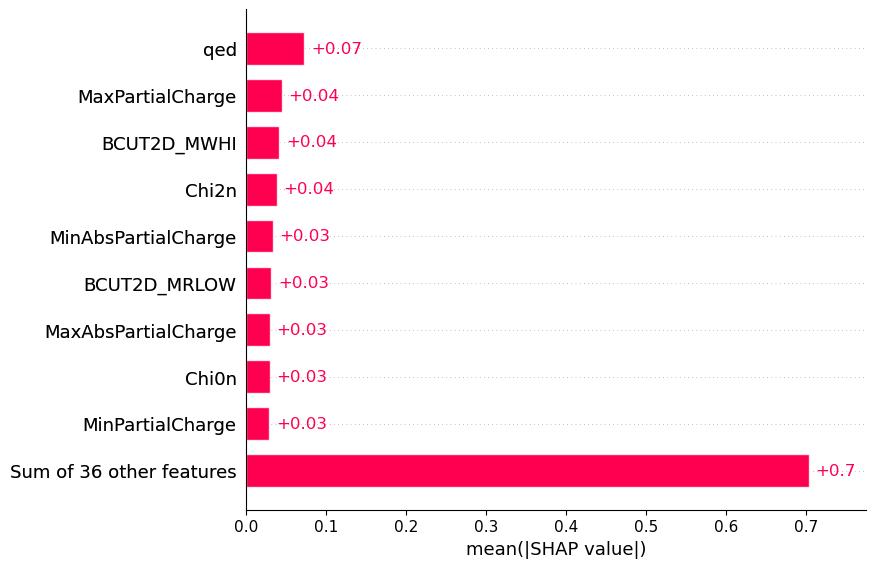

In [18]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


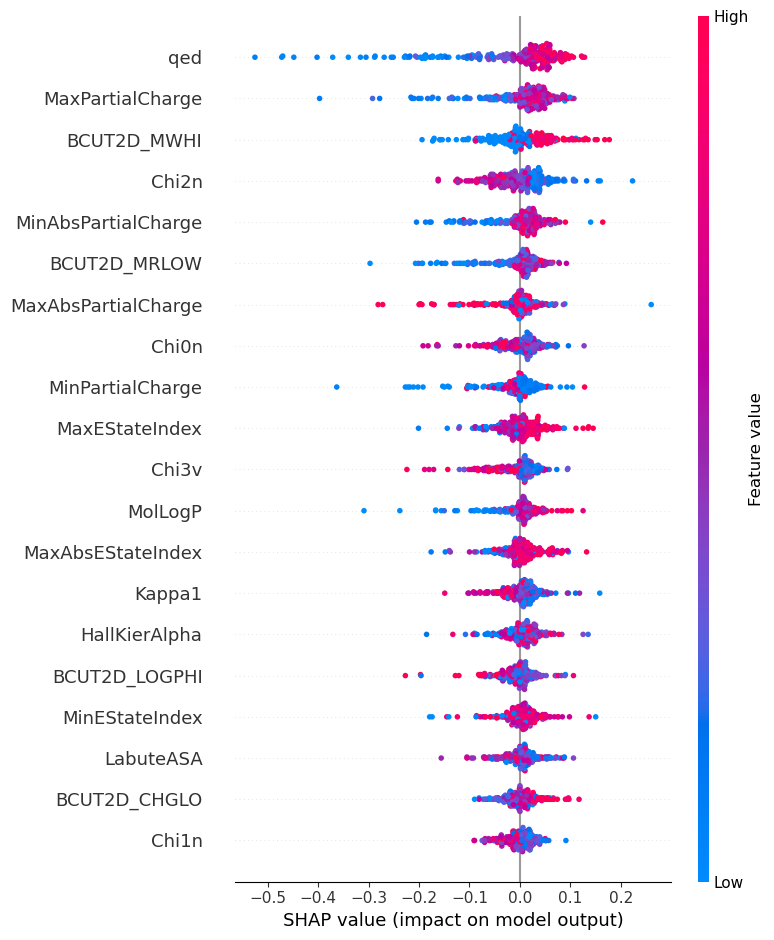

In [8]:
shap.summary_plot(shap_values)

In [19]:
df = pd.read_csv('./data/oral_avail_mol_desc/data_oral_avail_train_mol_desc.csv')
df_test = pd.read_csv('./data/oral_avail_mol_desc/data_oral_avail_test_mol_desc.csv')
x_train = df.iloc[:, :45]
y_train = df['label_cutoff_50%']
x_test = df_test.iloc[:, :45]
y_test = df_test['label_cutoff_50%']
data_type = 'MD'

seed_everything(SEED_NO)
model = joblib.load(os.path.join(trained_model_path, f'trained_rf_model_{data_type}_repeat_0_fold_1.pkl'))
# Fits the explainer
explainer = shap.Explainer(model.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

Permutation explainer: 291it [00:52,  4.55it/s]                         


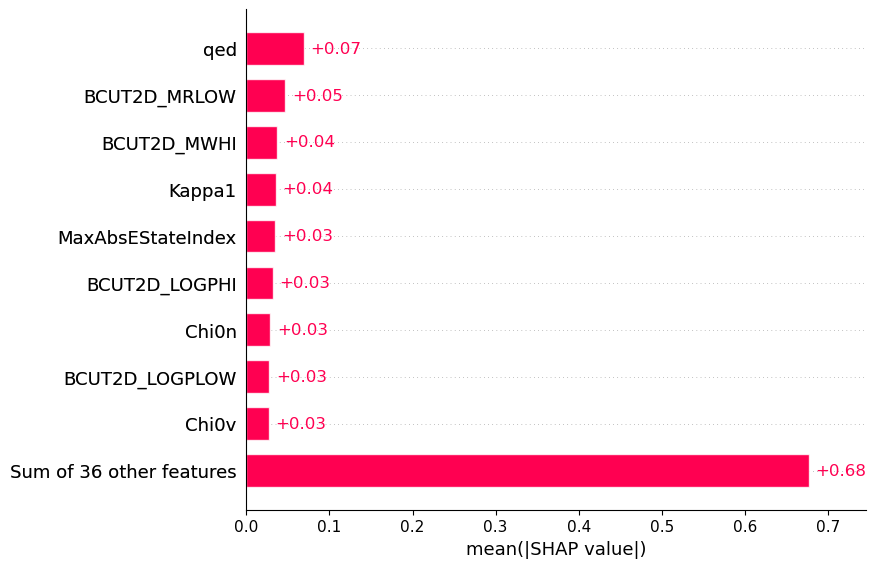

In [20]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


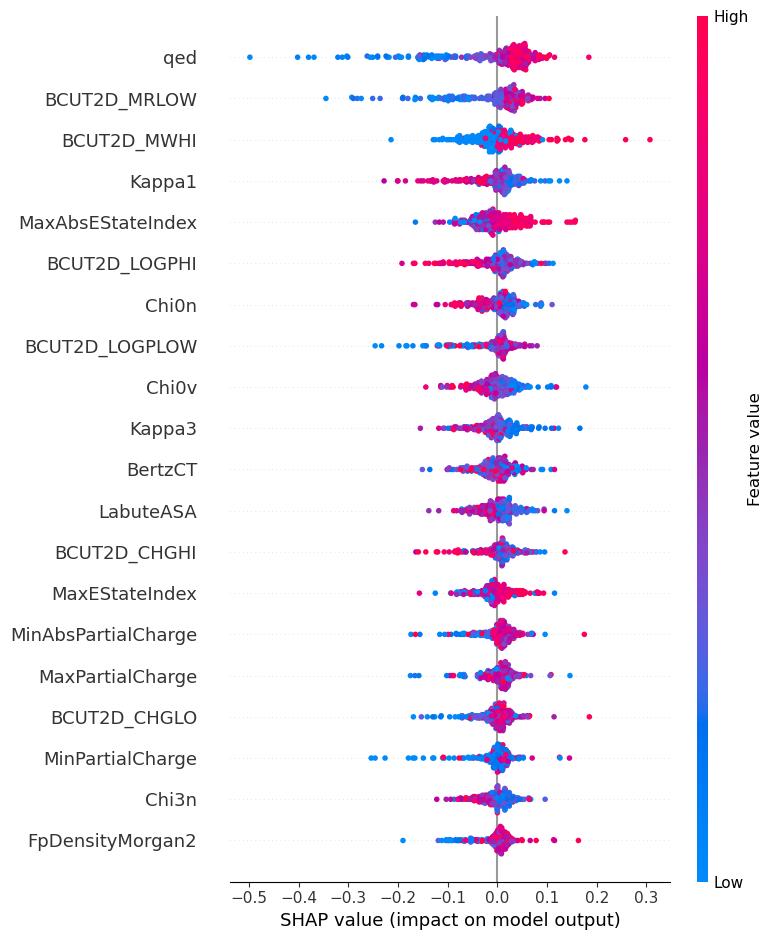

In [21]:
shap.summary_plot(shap_values)

In [22]:
df = pd.read_csv('./data/oral_avail_mol_desc/data_oral_avail_train_mol_desc.csv')
df_test = pd.read_csv('./data/oral_avail_mol_desc/data_oral_avail_test_mol_desc.csv')
x_train = df.iloc[:, :45]
y_train = df['label_cutoff_50%']
x_test = df_test.iloc[:, :45]
y_test = df_test['label_cutoff_50%']
data_type = 'MD'

seed_everything(SEED_NO)
model = joblib.load(os.path.join(trained_model_path, f'trained_rf_model_{data_type}_repeat_0_fold_2.pkl'))
# Fits the explainer
explainer = shap.Explainer(model.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

Permutation explainer: 291it [00:52,  4.53it/s]                         


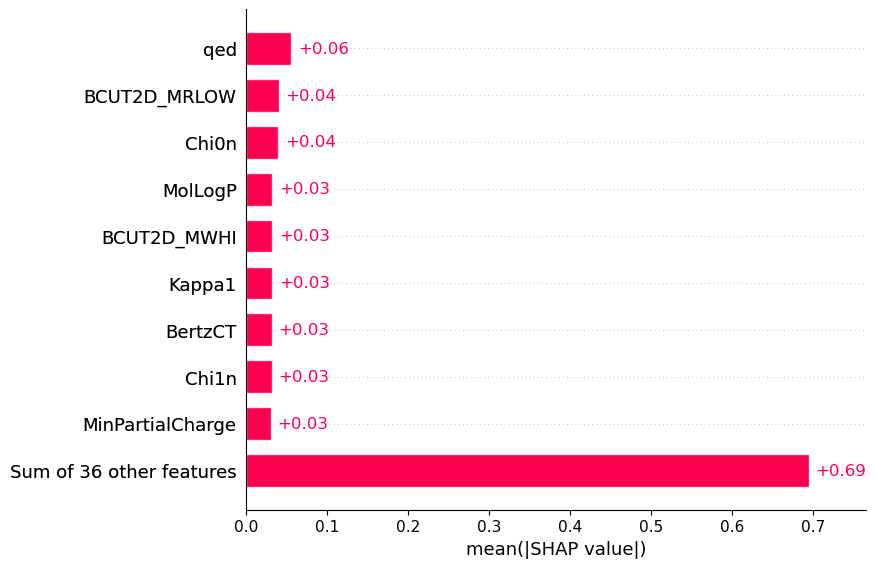

In [23]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


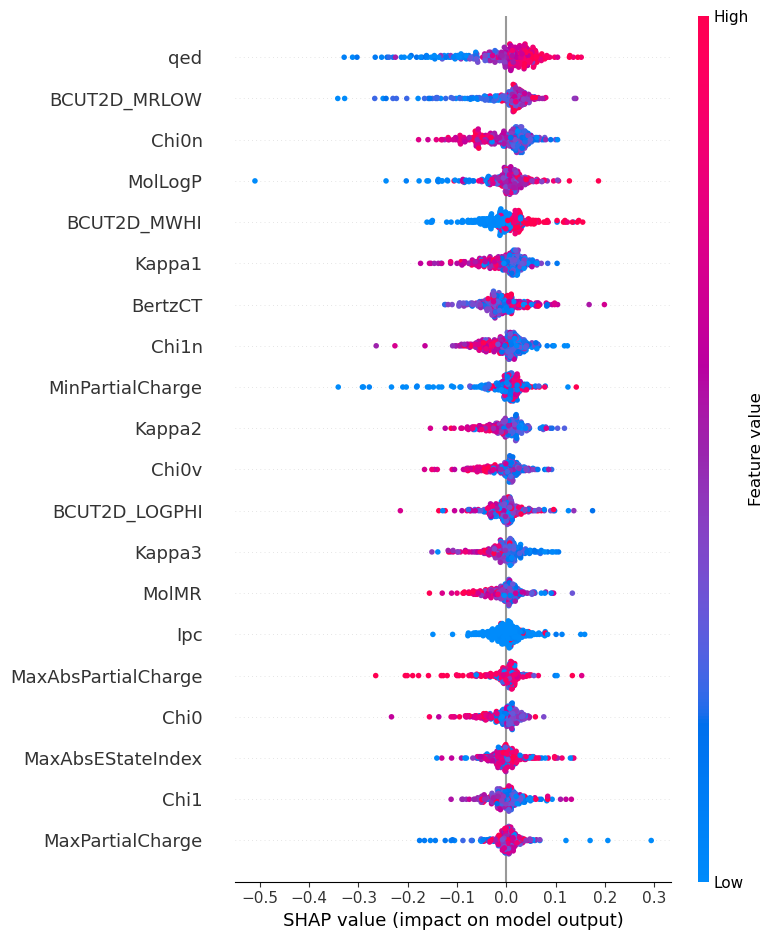

In [24]:
shap.summary_plot(shap_values)

In [25]:
df = pd.read_csv('./data/oral_avail_mol_desc/data_oral_avail_train_mol_desc.csv')
df_test = pd.read_csv('./data/oral_avail_mol_desc/data_oral_avail_test_mol_desc.csv')
x_train = df.iloc[:, :45]
y_train = df['label_cutoff_50%']
x_test = df_test.iloc[:, :45]
y_test = df_test['label_cutoff_50%']
data_type = 'MD'

seed_everything(SEED_NO)
model = joblib.load(os.path.join(trained_model_path, f'trained_rf_model_{data_type}_repeat_0_fold_3.pkl'))
# Fits the explainer
explainer = shap.Explainer(model.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

Permutation explainer: 291it [01:21,  2.88it/s]                         


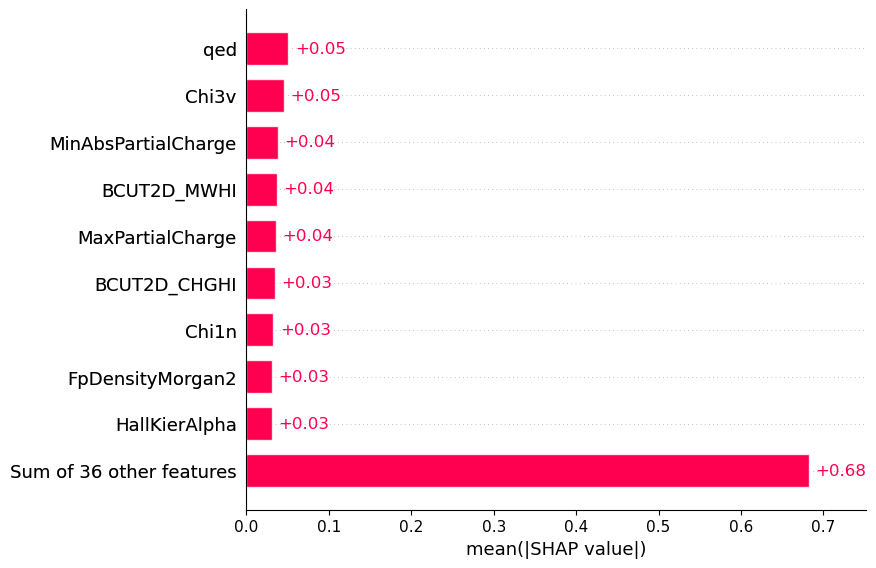

In [26]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


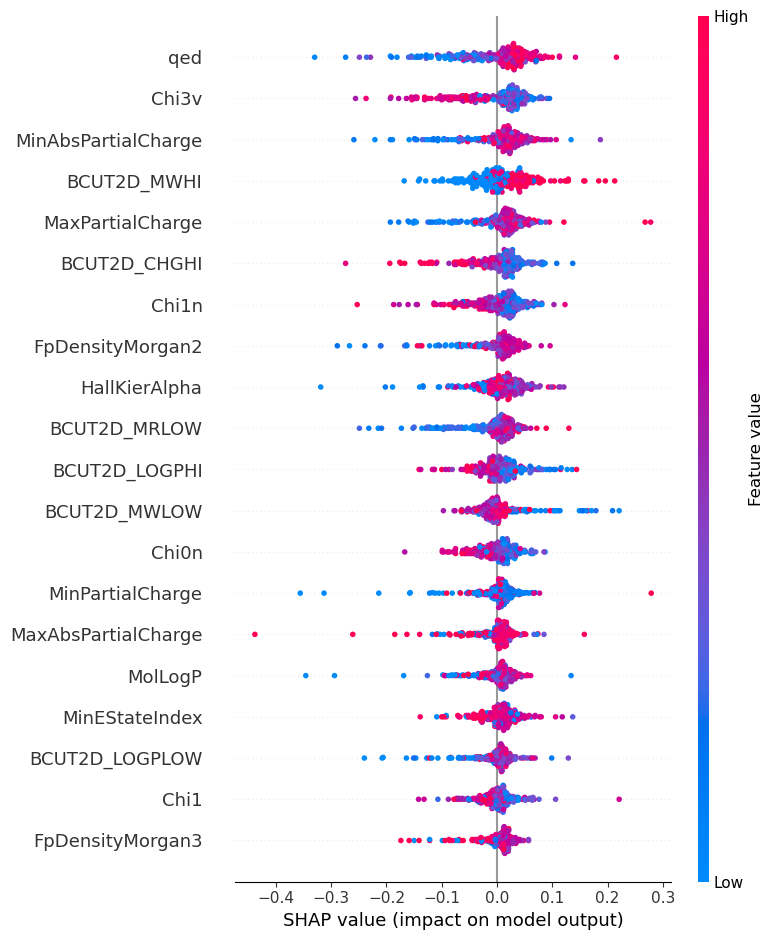

In [27]:
shap.summary_plot(shap_values)

In [28]:
df = pd.read_csv('./data/oral_avail_mol_desc/data_oral_avail_train_mol_desc.csv')
df_test = pd.read_csv('./data/oral_avail_mol_desc/data_oral_avail_test_mol_desc.csv')
x_train = df.iloc[:, :45]
y_train = df['label_cutoff_50%']
x_test = df_test.iloc[:, :45]
y_test = df_test['label_cutoff_50%']
data_type = 'MD'

seed_everything(SEED_NO)
model = joblib.load(os.path.join(trained_model_path, f'trained_rf_model_{data_type}_repeat_0_fold_4.pkl'))
# Fits the explainer
explainer = shap.Explainer(model.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

Permutation explainer: 291it [00:50,  4.60it/s]                         


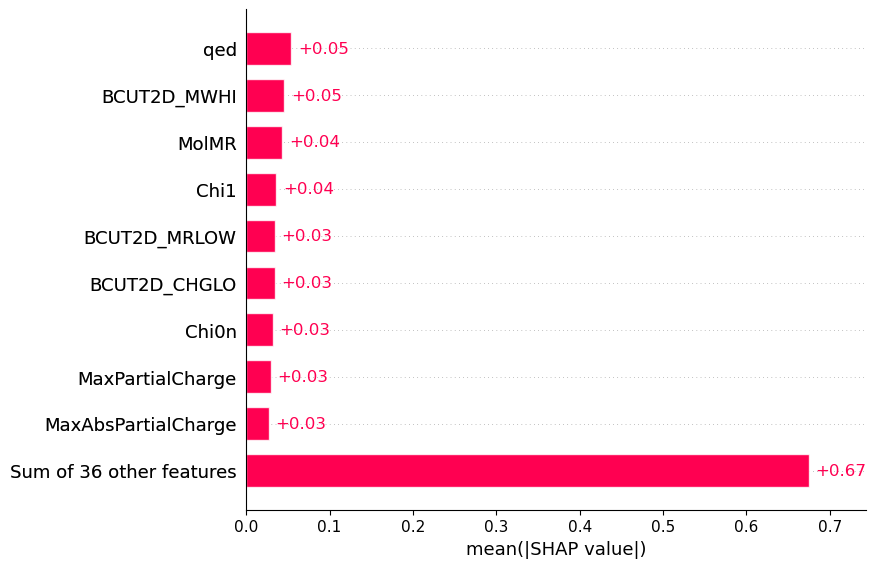

In [29]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


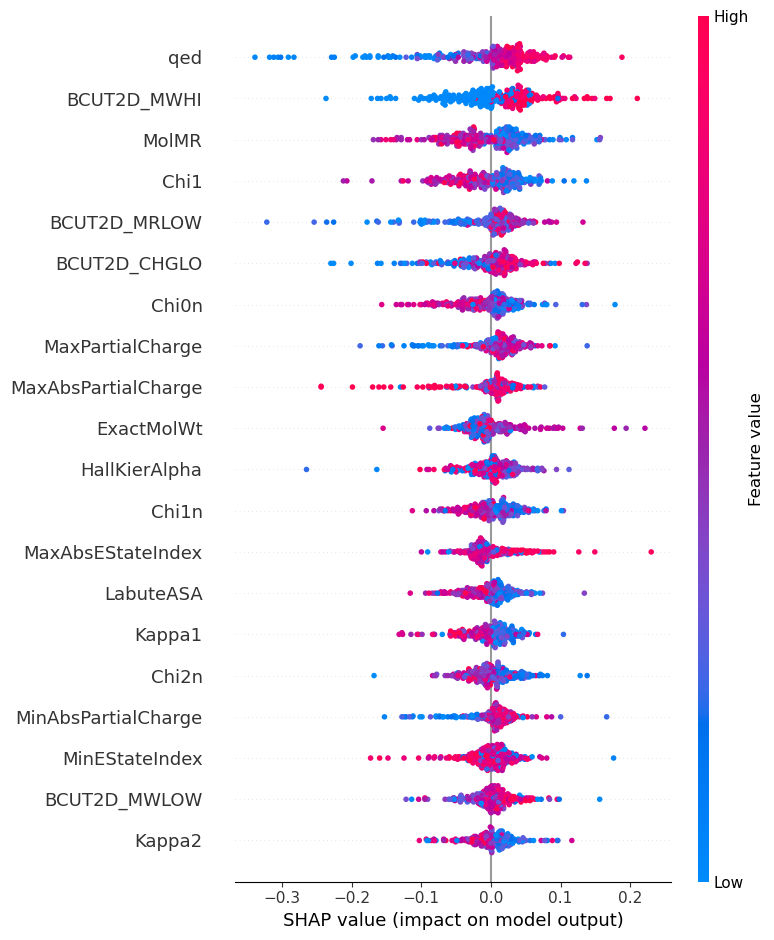

In [30]:
shap.summary_plot(shap_values)

## Applicability domain of model 

In [2]:
import pandas as pd 


low_sim_logS = pd.read_csv('./data/graph_data/trf_learning_logS_low/raw/logS_data_for_pretrained_model_low.csv')
mid_sim_logS = pd.read_csv('./data/graph_data/trf_learning_logS_mid/raw/logS_data_for_pretrained_model_mid.csv')
high_sim_logS = pd.read_csv('./data/graph_data/trf_learning_logS_high/raw/logS_data_for_pretrained_model_high.csv')

oral_avail_train = pd.read_csv('./data/graph_data/data_oral_avail_train/raw/data_oral_avail_train_50.csv')
oral_avail_test = pd.read_csv('./data/graph_data/data_oral_avail_test/raw/data_oral_avail_test_1_50.csv')

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def get_morgan_fp(mol, rad, bits):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, rad, bits)
    return np.array(fp)

In [4]:
# get all fp 

high_sim_logS_fp = []
for smile in high_sim_logS.SMILES:
    mol = Chem.MolFromSmiles(smile)
    fp = get_morgan_fp(mol, 2 , 1024)
    high_sim_logS_fp.append(fp)
    
high_sim_logS_fp_df = pd.DataFrame(high_sim_logS_fp)
high_sim_logS_fp_df['class'] = 'high'

mid_sim_logS_fp = []
for smile in mid_sim_logS.SMILES:
    mol = Chem.MolFromSmiles(smile)
    fp = get_morgan_fp(mol, 2 , 1024)
    mid_sim_logS_fp.append(fp)
    
mid_sim_logS_fp_df = pd.DataFrame(mid_sim_logS_fp)
mid_sim_logS_fp_df['class'] = 'mid'

low_sim_logS_fp = []
for smile in low_sim_logS.SMILES:
    mol = Chem.MolFromSmiles(smile)
    fp = get_morgan_fp(mol, 2 , 1024)
    low_sim_logS_fp.append(fp)
    
low_sim_logS_fp_df = pd.DataFrame(low_sim_logS_fp)
low_sim_logS_fp_df['class'] = 'low'

oral_avail_train_fp = []
for smile in oral_avail_train.smile:
    mol = Chem.MolFromSmiles(smile)
    fp = get_morgan_fp(mol, 2 , 1024)
    oral_avail_train_fp.append(fp)
    
oral_avail_train_fp_df = pd.DataFrame(oral_avail_train_fp)
oral_avail_train_fp_df['class']= 'train'

oral_avail_test_fp = []
for smile in oral_avail_test.smile:
    mol = Chem.MolFromSmiles(smile)
    fp = get_morgan_fp(mol, 2 , 1024)
    oral_avail_test_fp.append(fp)
    
oral_avail_test_fp_df = pd.DataFrame(oral_avail_test_fp)
oral_avail_test_fp_df['class'] = 'test'

In [5]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=50, random_state=SEED_NO)
high_sim_logS_fp_embedded = pca1.fit_transform(high_sim_logS_fp_df.iloc[:,:1024])

pca2 = PCA(n_components=50, random_state=SEED_NO)
mid_sim_logS_fp_embedded = pca2.fit_transform(mid_sim_logS_fp_df.iloc[:,:1024])

pca3 = PCA(n_components=50, random_state=SEED_NO)
low_sim_logS_fp_embedded = pca3.fit_transform(low_sim_logS_fp_df.iloc[:,:1024])

pca4 = PCA(n_components=50, random_state=SEED_NO)
oral_avail_train_fp_embedded = pca4.fit_transform(oral_avail_train_fp_df.iloc[:, :1024])

pca5 = PCA(n_components=50, random_state=SEED_NO)
oral_avail_test_fp_embedded = pca5.fit_transform(oral_avail_test_fp_df.iloc[:, :1024])

In [6]:
print('high sim solubililty')
print(np.sum(pca1.explained_variance_ratio_))

print('mid sim solubililty')
print(np.sum(pca2.explained_variance_ratio_))

print('low sim solubililty')
print(np.sum(pca3.explained_variance_ratio_))

print('oral avail train')
print(np.sum(pca4.explained_variance_ratio_))

print('oral avail test')
print(np.sum(pca5.explained_variance_ratio_))

high sim solubililty
0.49185305493315423
mid sim solubililty
0.4668575595154028
low sim solubililty
0.44693869216026083
oral avail train
0.44068236460810833
oral avail test
0.5459532208650137


In [7]:
# Embeds them using tsne 
from sklearn.manifold import TSNE

high_sim_logS_fp_embed = TSNE(n_components=2, random_state=SEED_NO).fit_transform(high_sim_logS_fp_embedded)
mid_sim_logS_fp_embed = TSNE(n_components=2, random_state=SEED_NO).fit_transform(mid_sim_logS_fp_embedded)
low_sim_logS_fp_embed = TSNE(n_components=2, random_state=SEED_NO).fit_transform(low_sim_logS_fp_embedded)
oral_avail_train_fp_embed = TSNE(n_components=2, random_state=SEED_NO).fit_transform(oral_avail_train_fp_embedded)
oral_avail_test_fp_embed = TSNE(n_components=2, random_state=SEED_NO).fit_transform(oral_avail_test_fp_embedded)



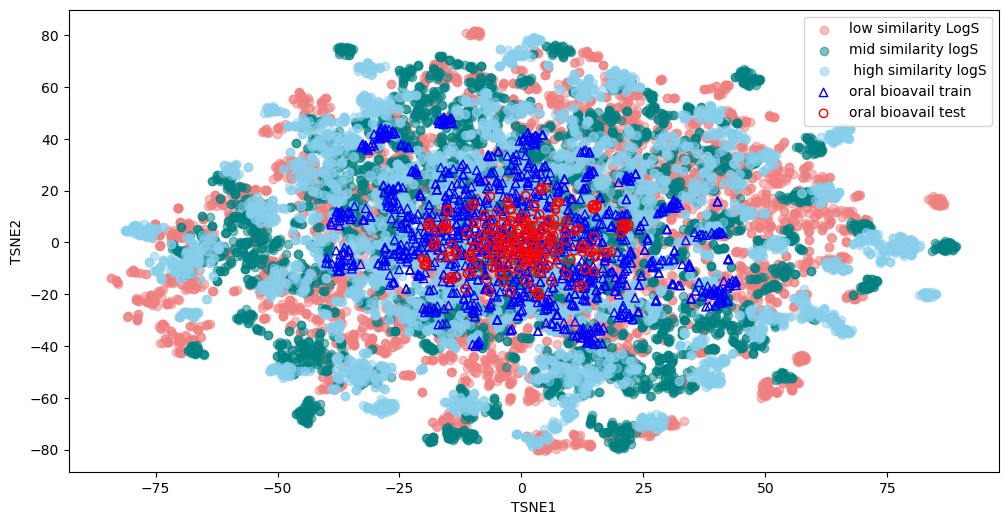

In [15]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,6))
low_sim = plt.scatter(low_sim_logS_fp_embed[:, 0], low_sim_logS_fp_embed[:,1], c='lightcoral', alpha=0.5)
mid_sim = plt.scatter(mid_sim_logS_fp_embed[:, 0], mid_sim_logS_fp_embed[:,1], c='teal', alpha=0.5)
high_sim = plt.scatter(high_sim_logS_fp_embed[:, 0], high_sim_logS_fp_embed[:,1], c='skyblue', alpha=0.5)
oa_train = plt.scatter(oral_avail_train_fp_embed[:, 0], oral_avail_train_fp_embed[:,1], facecolors='none', edgecolors='blue', marker='^')
oa_test = plt.scatter(oral_avail_test_fp_embed[:, 0], oral_avail_test_fp_embed[:,1], facecolors='none', edgecolors='red', marker='o')
plt.legend((low_sim, mid_sim, high_sim, oa_train, oa_test), ('low similarity LogS', 'mid similarity logS', ' high similarity logS', 'oral bioavail train', 'oral bioavail test'), loc='best')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')



plt.savefig('./shap figures/tsne_chemical_space.png', bbox_inches='tight')



### Fingerprints random forest models

In [18]:
# For morgan

df = pd.read_csv('./data/oral_avail_fingerprints/data_oral_avail_train_morgan.csv')
df_test = pd.read_csv('./data/oral_avail_fingerprints/data_oral_avail_test_morgan.csv')
x_train = df.iloc[:, :1024]
y_train = df['label_cutoff_50%']

x_test = df_test.iloc[:, :1024]
y_test = df_test['label_cutoff_50%']
n_repetitions = 5
trained_model_path = './random_forest_models/'
data_type = 'morgan'

start = timer()
train_rf_model(data_type, best_params_morgan, n_repetitions, x_train, y_train, trained_model_path)
ll_mean, ll_std, acc_mean, acc_std, f1_mean, f1_std, roc_auc_mean, roc_auc_std = test_rf_model(data_type, best_params_morgan,n_repetitions, x_train, x_test, y_train, y_test, trained_model_path)
end = timer()
print(f'Average time taken:', (end-start)/5)
print(f'logloss: {ll_mean:.3f}±{ll_std:.3f}')
print(f'acc: {acc_mean:.3f}±{acc_std:.3f}')
print(f'f1: {f1_mean:.3f}±{f1_std:.3f}')
print(f'roc_auc: {roc_auc_mean:.3f}±{roc_auc_std:.3f}')


Training Complete!
Average time taken: 1.3692775600000004
logloss: 0.592±0.012
acc: 0.684±0.013
f1: 0.738±0.020
roc_auc: 0.746±0.017


In [19]:
# For rdkfp

df = pd.read_csv('./data/oral_avail_fingerprints/data_oral_avail_train_rdkfp.csv')
df_test = pd.read_csv('./data/oral_avail_fingerprints/data_oral_avail_test_rdkfp.csv')
x_train = df.iloc[:, :1024]
y_train = df['label_cutoff_50%']

x_test = df_test.iloc[:, :1024]
y_test = df_test['label_cutoff_50%']
params = best_params_rdkfp
n_repetitions = 5
trained_model_path = './random_forest_models/'
data_type = 'rdkfp'

start = timer()
train_rf_model(data_type, best_params_rdkfp, n_repetitions, x_train, y_train, trained_model_path)
ll_mean, ll_std, acc_mean, acc_std, f1_mean, f1_std, roc_auc_mean, roc_auc_std = test_rf_model(data_type, best_params_rdkfp,n_repetitions, x_train, x_test, y_train, y_test, trained_model_path)
end = timer()
print(f'Average time taken:', (end-start)/5)
print(f'logloss: {ll_mean:.3f}±{ll_std:.3f}')
print(f'acc: {acc_mean:.3f}±{acc_std:.3f}')
print(f'f1: {f1_mean:.3f}±{f1_std:.3f}')
print(f'roc_auc: {roc_auc_mean:.3f}±{roc_auc_std:.3f}')


Training Complete!
Average time taken: 0.3634355600000049
logloss: 0.610±0.009
acc: 0.670±0.026
f1: 0.724±0.026
roc_auc: 0.724±0.022


In [20]:
# For maccskeys

df = pd.read_csv('./data/oral_avail_fingerprints/data_oral_avail_train_maccskeys.csv')
df_test = pd.read_csv('./data/oral_avail_fingerprints/data_oral_avail_test_maccskeys.csv')
x_train = df.iloc[:, :167]
y_train = df['label_cutoff_50%']

x_test = df_test.iloc[:, :167]
y_test = df_test['label_cutoff_50%']
params = best_params_maccskeys
n_repetitions = 5
trained_model_path = './random_forest_models/'
data_type = 'maccskeys'

start = timer()
train_rf_model(data_type, best_params_maccskeys, n_repetitions, x_train, y_train, trained_model_path)
ll_mean, ll_std, acc_mean, acc_std, f1_mean, f1_std, roc_auc_mean, roc_auc_std = test_rf_model(data_type, best_params_maccskeys,n_repetitions, x_train, x_test, y_train, y_test, trained_model_path)
end = timer()
print(f'Average time taken:', (end-start)/5)
print(f'logloss: {ll_mean:.3f}±{ll_std:.3f}')
print(f'acc: {acc_mean:.3f}±{acc_std:.3f}')
print(f'f1: {f1_mean:.3f}±{f1_std:.3f}')
print(f'roc_auc: {roc_auc_mean:.3f}±{roc_auc_std:.3f}')


Training Complete!
Average time taken: 0.8146830399999999
logloss: 0.592±0.010
acc: 0.687±0.019
f1: 0.738±0.018
roc_auc: 0.742±0.012
